# Overview

This notebook (should) get you started with some time series analysis in python. Note, the stats models package is actively maintained...but if you want to do serious statistics, just get `R`.


Useful Link(s):
- http://pyspectrum.readthedocs.io/en/latest/index.html
- https://www.statsmodels.org/stable/install.html





# A note you should read...
"Rob Hyndman’s excellent forecast package in R is probably the most popular option, and Google and Twitter have both released packages with more specific time series functionality — CausalImpact and AnomalyDetection, respectively. As far as we can tell, there are few open source software packages for forecasting in Python."
    - Facebook
    
    
    
what does this mean? In short, there are limited "traditional" forecasting/timeseries functionalities avaliable for python. e.g. attempting to forecast a SVARIMA(2,3,1)(4,2,12) with drift is not eaisly possible. Strangely enough, there are many packages that enable spectral analysis (many relying on numpy's `numpy.fft.fftn()` or `nupy.fft.fft()` methods.  

## Useful packages

In [1]:
import pandas as pd
import statsmodels.api as sm

from spectrum import Periodogram
#% matplotlib inline

import matplotlib as mp

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!pwd

/Users/jameshorine/repos/TimeSeriesTalk/code


In [3]:
beer = pd.read_csv("../data/quarterly-beer-production-in-aus.csv", header=0, index_col=0)

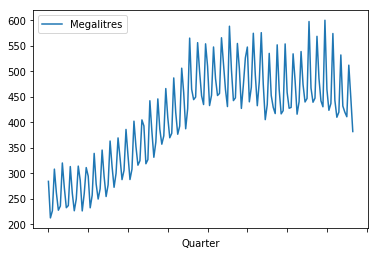

In [157]:
beer.plot()

In [4]:
beer.head()

,Megalitres
Quarter,
1956Q1,284.4
1956Q2,212.8
1956Q3,226.9
1956Q4,308.4
1957Q1,262.0


# Sample Autocorrelation

<bound method Figure.show of <matplotlib.figure.Figure object at 0x1c17e0a898>>

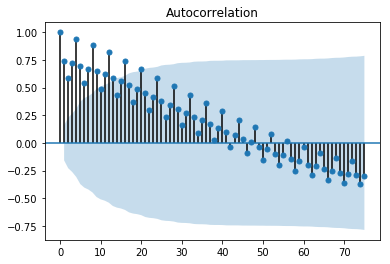

In [7]:
sm.graphics.tsa.plot_acf(beer, lags = 75).show

# Sample Partial-Autocorrelation

<bound method Figure.show of <matplotlib.figure.Figure object at 0x1c17f0ec88>>

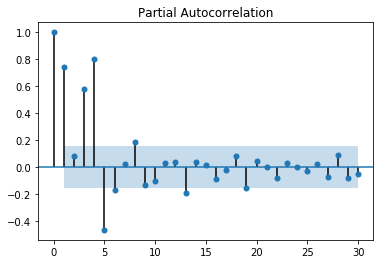

In [8]:
sm.graphics.tsa.plot_pacf(beer, lags = 30).show

# Sample Lagplots

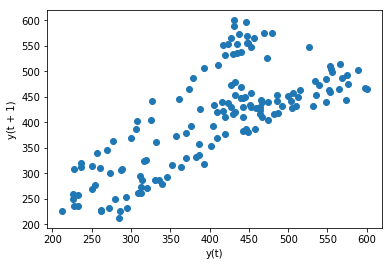

In [20]:
pd.plotting.lag_plot(beer, lag=1)

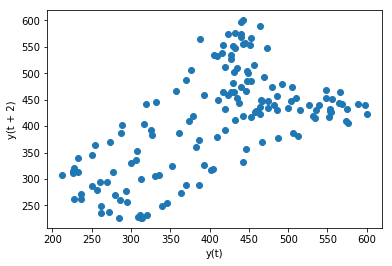

In [21]:
pd.plotting.lag_plot(beer, lag = 2)

# Sample Power Spectrum 

The Sample Power Spectrum, or Sample Power Spectral Density, or Sample Periodogram, Or Sample Spectrum... same math, many names depending on the background of the practitioner. e.g. I know it as the Periodogram, because I learned from a...wiser...frumpy frequentist. 

The below code was my last (frusturated) attempt at delivering a reasonable estimate of the PSD. Many packages do it wrong, or in a way that is not abstract enough to handle other, potentially useful data strucutres (like series and data frames). 

Note 1: this assume the input series is REAL, i.e. NOT complex (of the form `a+bi`). In which case, the sample PSD calculation is merely the absolute-value (modulus in the complex field) squared of the real part of a real signal. In the complex case, you would want to look beyond a frequency of 0.5 as your signal almost certinaly contains information in that domain (Hermitian, NOT symmetric).

Note 2: period = 1/ frequency 
 - e.g. 1/0.25 = 4, the sample data below arrives as what kind of data? what is the sampling scheme? 4 quarters per...? 

In [199]:
sample_spectrum = pd.DataFrame()

In [200]:
sample_spectrum["log_power"] = numpy.log(pd.Series(abs(numpy.fft.fft(beer['Megalitres']))**2).iloc[0:((len(beer)//2) +1)])
sample_spectrum["fourier_frequency"] = pd.DataFrame([range(0,len(beer)//2)]).T.divide(len(beer))

In [202]:
sample_spectrum.shape

(78, 2)

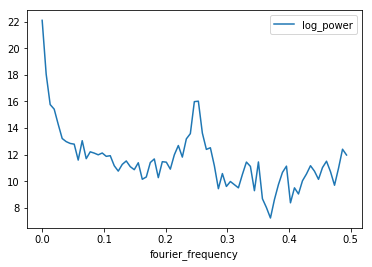

In [203]:
sample_spectrum.plot(x='fourier_frequency', y='log_power')